# Simulations de Marches Aléatoires et Évaluation du Fair Price d'une valeur

## Objectif Général :
L'objectif de cet exercice est de simuler des trajectoires de prix pour une action donnée (ici Apple, ticker : AAPL) en utilisant des marches aléatoires basées sur des paramètres statistiques estimés à partir de données historiques.

## Structure du Notebook :

### Fonctions

1. **Téléchargement et validation des données :**
   - Validation du ticker de l'action et des périodes
   - Téléchargement des prix historiques et gestion des valeurs manquantes

2. **Simulation des marches aléatoires :**
   - Estimation des paramètres statistiques
   - Génération des trajectoires de prix futurs
   - Evalution du fair price

### Main 

# Importantion des bibliothèques nécessaires

In [88]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import datetime as dt

# Fonctions

## 1. Téléchargement et validation des données

### A. Validation du ticker de l'action et des périodes

Fonction permettant de vérifier la validité d'un ticker saisi par l'utilisateur (par exemple, AAPL ou MSFT) à l'aide de yfinance. Le ticker est retourné uniquement si des données valides sont disponibles sinon l'utilisateur est invité à saisir un autre ticker.

In [89]:
def validate_ticker(default="AAPL"):
    while True:
        ticker = input(f"Entrez le ticker (par ex. AAPL, MSFT, TSLA) (par défaut : {default}) : ").strip().upper()
        ticker = ticker if ticker else default
        stock = yf.Ticker(ticker)
        stock.history(period="1d")
        prices = stock.history(period="1d")
        if not prices.empty:
            return ticker  
        print(f"Le ticker {ticker} n'est pas valide. Veuillez réessayer.")

Fonction permettant de valider une date saisie par l'utilisateur en s'assurant qu'elle respecte le format YYYY-MM-DD. Si une date par défaut est spécifiée et que l'utilisateur ne fournit aucune saisie, cette valeur est automatiquement utilisée. Si un DataFrame contenant des données de prix est fourni, la date est vérifiée pour correspondre à un jour de trading valide présent dans l'index des données. En cas de format incorrect ou de date non valide, un message d'erreur est affiché, et une nouvelle saisie est demandée. Une fois validée, la date est retournée sous forme d'objet datetime.date.

In [90]:
def validate_date(prompt, default=None, prices=None):
    while True:
        try:
            date_input = input(f"{prompt} (par défaut : {default}) : ").strip()
            date_input = date_input if date_input else default
            date = dt.datetime.strptime(date_input, "%Y-%m-%d").date()
            if prices is not None and date not in pd.to_datetime(prices.index).date:
                print(f"Erreur : La date {date} doit être un jour de trading valide dans les données.")
                continue
            return date
        except ValueError:
            print("Erreur : La date saisie est invalide. Veuillez respecter le format AAAA-MM-JJ.")


Fonction permettant de valider une plage de dates saisie par l'utilisateur. Chaque date est vérifiée individuellement à l'aide de la fonction validate_date, qui s'assure de leur validité (par exemple, correspondance à un jour de trading si des données de prix sont fournies). Ensuite, la fonction vérifie que la date de début est antérieure ou égale à la date de fin. En cas d'erreur, un message est affiché, et l'utilisateur est invité à saisir à nouveau les dates. Une fois validée, la plage de dates est retournée sous forme d'un tuple d'objets datetime.date.

In [91]:
def validate_date_range(prompt_start, prompt_end, default_start=None, default_end=None, prices=None):
    while True:
        start_date = validate_date(prompt_start, default_start, prices)
        end_date = validate_date(prompt_end, default_end, prices)
        if start_date > end_date:
            print("Erreur : La date de fin doit être postérieure ou égale à la date de début.")
            continue
        return start_date, end_date

### B. Téléchargement des prix historiques et gestion des valeurs manquantes.

Fonction permettant de télécharger les données de prix de clôture pour une action donnée sur une période spécifiée en utilisant yfinance. Si des données sont absentes ou invalides, un message d'erreur est affiché, et une exception est levée. En cas de valeurs manquantes dans les données téléchargées, celles-ci sont remplacées à l'aide des méthodes ffill() et bfill() pour assurer la continuité. Une fois les données valides, elles sont retournées sous forme de DataFrame.

In [92]:
def download_prices(ticker, start_date, end_date):
    print(f"Téléchargement des données pour {ticker} de {start_date} à {end_date}...")
    prices = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))[['Close']]
    if prices.empty:
        raise ValueError(f"Aucune donnée téléchargée pour {ticker}. Vérifiez les dates ou le ticker.")
    if prices.isnull().values.any():
        print("Attention : Des valeurs manquantes ont été détectées. Elles seront remplacées par ffill() et bfill().")
        prices = prices.ffill().bfill()
    print(f"Données téléchargées avec succès pour {ticker}.")
    return prices

## 2. Simulations des marches aléatoires

### A. Estimation des paramètres statistiques

Fonction permettant de calculer les rendements logarithmiques d'une action sur une période donnée (données plus stable que celle des prix bruts), ainsi que leur moyenne et leur écart-type. Si une sous-période est spécifiée, les données de prix sont filtrées en conséquence. En cas d'absence de données pour la période sélectionnée, une exception est levée. Les rendements sont calculés en prenant la différence logarithmique des prix de clôture consécutifs, après suppression des valeurs manquantes. La fonction retourne les rendements sous forme de série, leur moyenne et leur écart-type.

In [109]:
def calculate_stat_returns(prices, start_sub_period=None, end_sub_period=None):
    if start_sub_period and end_sub_period:
        prices = prices.loc[start_sub_period:end_sub_period]
    if prices.empty:
        raise ValueError(f"Aucune donnée disponible pour la période {start_sub_period} à {end_sub_period}.")
    returns = np.log(prices['Close']).diff().dropna()
    return returns, returns.mean(), returns.std()

### B. Génération des trajectoires de prix futures

Fonction permettant de simuler des trajectoires de prix futurs pour un actif donné à l'aide de la méthode Monte Carlo. À partir d'une date initiale, d'un prix initial, d'une moyenne et d'un écart-type, la fonction génère un nombre spécifié de simulations sur une période donnée. Les marches aléatoires sont calculées en utilisant des variations normalisées appliquées au prix initial. Les trajectoires simulées sont ensuite tracées sur un graphique aux côtés de l'historique des prix réels pour une comparaison visuelle. La fonction retourne un tableau contenant les prix finaux des simulations et les dates associées.

In [94]:
def monte_carlo_simulation(ticker, prices, nb_simulation, nb_step, initial_date, initial_price, mean, std):
    if pd.Timestamp(initial_date) not in prices.index:
        raise ValueError(f"initial_date ({initial_date}) n'est pas une date valide dans l'historique des prix.")

    dates = pd.bdate_range(start=initial_date, periods=nb_step + 1, freq='B')
    simulations = np.zeros((nb_simulation, nb_step + 1))

    for i in range(nb_simulation):
        random_walk = np.random.normal(mean, std, nb_step)
        simulations[i, :] = initial_price * np.exp(np.cumsum(np.insert(random_walk, 0, 0)))

    plt.figure(figsize=(12, 8))
    plt.plot(prices.index, prices['Close'], color='red', linewidth=2, label=f'Historique des prix de {ticker}')
    plt.scatter(initial_date, initial_price, color='black', zorder=3, label="Début des simulations")

    for i in range(min(nb_simulation, 100)):
        plt.plot(dates, simulations[i, :], linewidth=1, alpha=0.5)
        
    plt.title(f"Simulation Monte Carlo pour {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid()
    plt.show()

    return simulations[:, -1], dates

### C. Evaluation du fair price

Fonction permettant de calculer le prix équitable (fair price) d'un actif en actualisant les prix moyens finaux issus de simulations Monte Carlo à la date actuelle. Le calcul utilise une formule de valeur actualisée basée sur un taux sans risque spécifié et la durée en années entre la date initiale et la date finale des simulations. La fonction retourne le prix équitable, qui peut être utilisé comme une estimation de la juste valeur de l'actif.

In [95]:
def calculate_fair_price(mean_final_price, dates, risk_free_rate):
    t = (dates[-1] - dates[0]).days / 365
    fair_price = mean_final_price * np.exp(-risk_free_rate * t)
    return fair_price

# Variables par défaut

In [96]:
# Date du jour
today = date.today().strftime("%Y-%m-%d")

# Plage téléchargement de l'historique
default_start_date = "2023-01-03"
default_end_date = today

# Plage pour les calculs des paramètres statistiques
default_start_sub_period = "2023-01-03"
default_end_sub_period = "2024-03-01"

# Plage pour les marches aléatoires
default_start_sim_period = "2024-10-04"
default_end_sim_period = today

# Nombre de marches aléatoires
default_nb_simulation = 10

# Taux sans risque 
default_risk_free_rate = 0.03

# Main

In [97]:
# Choix et validation du ticker
ticker = validate_ticker()

In [98]:
# Choix et validation de la période de téléchargement de l'historique
start_date, end_date = validate_date_range(
    f"Entrez la date de début du téléchargement de l'historique des prix de {ticker} :",
    f"Entrez la date de fin du téléchargement de l'historique des prix de {ticker} :",
    default_start_date,
    default_end_date
)

In [99]:
# Téléchargement des données historiques
prices = download_prices(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed

Téléchargement des données pour AAPL de 2023-01-03 à 2024-12-08...
Données téléchargées avec succès pour AAPL.


In [100]:
# Choix et validation de la sous-période pour les paramètres statistiques
start_sub_period, end_sub_period = validate_date_range(
    f"Entrez la date de début pour le calcul des paramètres statistiques de {ticker} :",
    f"Entrez la date de fin pour le calcul des paramètres statistiques de {ticker} :",
    default_start_sub_period,
    default_end_sub_period,
    prices
)

In [101]:
# Calcul des rendements et des paramètres statistiques à partir de la fonction calculate_stat_returns
returns, mean, std = calculate_stat_returns(prices, start_sub_period, end_sub_period)
variance = std ** 2

print(f"Rendements calculés pour la période {start_sub_period} à {end_sub_period} :")
print(f"Valeur attendue (moyenne des rendements) : {mean:.6f}")
print(f"Écart-type des rendements : {std:.6f}")
print(f"Variance des rendements : {variance:.6f}")

Rendements calculés pour la période 2023-01-03 à 2024-03-01 :
Valeur attendue (moyenne des rendements) : 0.001245
Écart-type des rendements : 0.012487
Variance des rendements : 0.000156


In [102]:
# Choix et validation du début de la période pour les marches aléatoires la fin est par défaut aujourd'hui
start_sim_period = validate_date(
    f"Entrez la date de début pour les marches aléatoires :",
    default_start_sim_period,
    prices
)

In [103]:
# Choix et validation du nombre de marches aléatoires
nb_simulation = int(input(f"Entrez le nombre de simulations à effectuer (par défaut : {default_nb_simulation}) : ") or default_nb_simulation)

In [104]:
# Choix et validation du taux sans risque
risk_free_rate = float(input(f"Entrez le taux sans risque (par défaut : {default_risk_free_rate}) : ") or default_risk_free_rate)

In [105]:
# Calcul du nombre de pas pour la marche aléatoire en fonction de la période de simulation
nb_step = len(pd.bdate_range(start=start_sim_period, end=end_date)) -1 # -1 car on a besoin de la veille de la date de fin

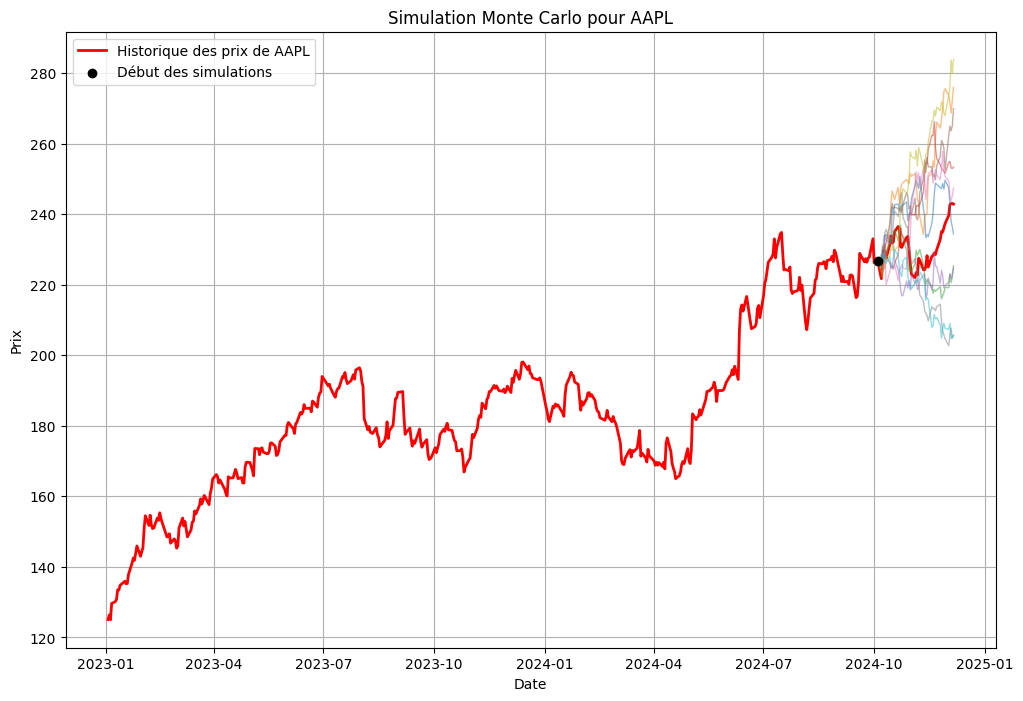

In [106]:
# Simulation Monte Carlo
final_prices, simulation_dates = monte_carlo_simulation(
    ticker=ticker,
    prices=prices,
    nb_simulation=nb_simulation,
    nb_step=nb_step,
    initial_date=start_sim_period,
    initial_price=prices.loc[pd.Timestamp(start_sim_period), 'Close'],
    mean=mean,
    std=std
)

In [107]:
# Calcul de la moyenne des prix finaux des marches aléatoires
mean_final_price = np.mean(final_prices)
print(f"La moyenne des prix finaux des simulations est de {mean_final_price:.2f}")

La moyenne des prix finaux des simulations est de 242.59


In [108]:
# Calcul du prix équitable
fair_price = calculate_fair_price(
    mean_final_price=mean_final_price,
    dates=simulation_dates,
    risk_free_rate=risk_free_rate
)

print(f"\nLe fair price estimé pour {ticker} est de : {fair_price:.2f}")


Le fair price estimé pour AAPL est de : 241.34
